# Glass Detection from LiDAR Intensity - Project Update

## Overview
Here is the current progress on detecting glass surfaces in LiDAR point clouds using intensity patterns. As we've discussed, when a LiDAR beam hits glass at a perpendicular angle, it creates a characteristic **Gaussian intensity pattern**. This notebook sets up the pipeline for us to experiment with detection algorithms.

## Dataset
- **Sensors**: Hesai and Ouster LiDAR
- **Data**: Point cloud files from both sensors
- **Format**: PLY files with fields: `x, y, z, nx, ny, nz, intensity, ring, return, label`
- **Labels**: `0=unlabeled, 1=normal, 2=glass, 3=mirror, 4=other_reflective, 5=reflection, 6=obstacle_behind`

## Current Status & Next Steps
I've set up the infrastructure so we can focus on the detection logic. The notebook currently handles:
1. Data loading and preprocessing
2. Unrolled 2D intensity image creation
3. Visualization tools
4. Ground truth comparison

**Action Item**: Use the designated cell below to implement and test new glass detection methods. We need to improve upon the initial baselines.

## Methods I've Explored So Far
I tried a few approaches to get us started, with mixed results:
1. **Blob Detection (DoG/LoG)**: Fast but struggled with broken patterns from window frames and also too many false positives
2. **Intensity Divergence**: Detected intensity changes but also picked up edges/frames of windows, so again too many false positives, maybe i implemented it wrong, this idea is worth exploring.
3. **Intensity Sequence**: Scanned rings for low→peak→low patterns with vertical validation, couldnt get it to work.

Let's iterate on these or try something capable of detecting the gaussian pattern. 

---
## 1. Setup and Configuration

In [114]:
# %pip install numpy matplotlib scipy opencv-python open3d
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Tuple
from scipy.spatial.transform import Rotation
import cv2
import open3d as o3d
from collections import defaultdict

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [ ]:
# ============================================================================
# CONFIGURATION - UPDATE THIS PATH
# ============================================================================

# Path to the folder containing your data
DATA_FOLDER = Path("/path/to/your/data/folder")  # UPDATE THIS!

# Expected structure:
# data_folder/
#   ├── hesai/
#   │   ├── timestamp1.ply
#   │   ├── timestamp2.ply
#   │   └── timestamp3.ply
#   ├── ouster/
#   │   ├── timestamp1.ply
#   │   ├── timestamp2.ply
#   │   └── timestamp3.ply
#   ├── hesai_pose.txt
#   ├── ouster_pose.txt
#   └── images/ (optional)
#       ├── timestamp1.jpg
#       └── ...

@dataclass
class Config:
    """Configuration for 2D intensity image creation."""
    AZIMUTH_WIDTH: int = 360  # Horizontal resolution of 2D image
    # Normalization method: 'min_max', 'robust_min_max', 'log', or None
    NORMALIZATION_METHOD: str = 'robust_min_max' 
    FIRST_RETURN_ONLY: bool = True  # Use only first returns

config = Config()

print(f"Data folder: {DATA_FOLDER}")
print(f"Configuration: {config}")

Data folder: /Volumes/Hemanth SSD/sample_data
Configuration: Config(AZIMUTH_WIDTH=360, NORMALIZATION_METHOD='robust_min_max', FIRST_RETURN_ONLY=True)


---
## 2. Data Structures

In [116]:
@dataclass
class PointCloudData:
    """Container for point cloud data."""
    sensor_name: str
    filename: str
    timestamp: float
    
    # Raw data
    points_raw: np.ndarray      # (N, 3) - sensor frame
    points_world: np.ndarray    # (N, 3) - world frame
    intensities: np.ndarray     # (N,) - raw intensity values
    rings: np.ndarray           # (N,) - ring/channel IDs
    returns: np.ndarray         # (N,) - return number (1, 2, ...)
    labels: np.ndarray          # (N,) - ground truth labels
    
    # Metadata
    num_rings: int
    intensity_range: Tuple[float, float]
    
    def __repr__(self):
        return (f"PointCloudData({self.sensor_name}, {self.filename}, "
                f"{len(self.points_raw):,} points, {self.num_rings} rings)")

@dataclass
class IntensityImage:
    """Container for 2D intensity image."""
    image: np.ndarray           # (H, W) - mean intensity per pixel
    point_to_pixel: Dict        # Mapping from 3D point indices to 2D pixels
    
    @property
    def shape(self):
        return self.image.shape
    
    def __repr__(self):
        return f"IntensityImage({self.shape[0]}×{self.shape[1]})"

---
## 3. Data Loading

Functions to load point clouds and transform them to world coordinates.

In [117]:
class DataLoader:
    """Loads and processes LiDAR point cloud data."""
    
    def __init__(self, data_folder: Path, config: Config):
        self.data_folder = Path(data_folder)
        self.config = config
        
        # Load pose files
        self.poses = {
            'hesai': self._load_poses('hesai_pose.txt'),
            'ouster': self._load_poses('ouster_pose.txt')
        }
    
    def _load_poses(self, filename: str) -> np.ndarray:
        """Load pose file (timestamp, tx, ty, tz, qx, qy, qz, qw)."""
        pose_file = self.data_folder / filename
        if not pose_file.exists():
            raise FileNotFoundError(f"Pose file not found: {pose_file}")
        return np.loadtxt(pose_file)
    
    @staticmethod
    def _load_ply(filepath: Path) -> np.ndarray:
        """Load PLY file (skipping header)."""
        with open(filepath, 'r') as f:
            while True:
                line = f.readline().strip()
                if line == 'end_header':
                    break
            return np.loadtxt(f)
    
    def load_point_cloud(self, sensor: str, ply_file: Path) -> PointCloudData:
        """
        Load a single point cloud file.
        
        Args:
            sensor: 'hesai' or 'ouster'
            ply_file: Path to .ply file
        
        Returns:
            PointCloudData object
        """
        # Extract timestamp from filename
        timestamp = float(ply_file.stem)
        
        # Load PLY data
        # Columns: x, y, z, nx, ny, nz, intensity, ring, return, label
        raw_data = self._load_ply(ply_file)
        
        points_raw = raw_data[:, :3]
        intensities = raw_data[:, 6]
        rings = raw_data[:, 7].astype(int)
        returns = raw_data[:, 8].astype(int)
        labels = raw_data[:, 9].astype(int)
        
        # Filter to first returns only (optional)
        if self.config.FIRST_RETURN_ONLY:
            mask = (returns == 1)
            points_raw = points_raw[mask]
            intensities = intensities[mask]
            rings = rings[mask]
            returns = returns[mask]
            labels = labels[mask]
        
        # Find closest pose
        poses = self.poses[sensor.lower()]
        idx = np.argmin(np.abs(poses[:, 0] - timestamp))
        pose = poses[idx]
        
        # Transform to world frame
        R = Rotation.from_quat(pose[4:8]).as_matrix()
        T = pose[1:4]
        points_world = (R @ points_raw.T).T + T
        
        # Metadata
        num_rings = int(np.max(rings)) + 1
        intensity_range = (np.min(intensities), np.max(intensities))
        
        return PointCloudData(
            sensor_name=sensor,
            filename=ply_file.name,
            timestamp=timestamp,
            points_raw=points_raw,
            points_world=points_world,
            intensities=intensities,
            rings=rings,
            returns=returns,
            labels=labels,
            num_rings=num_rings,
            intensity_range=intensity_range
        )
    
    def load_all(self) -> Dict[float, Dict[str, PointCloudData]]:
        """Load all point clouds grouped by timestamp."""
        # Group by timestamp
        timestamp_groups = defaultdict(dict)
        
        for sensor in ['hesai', 'ouster']:
            sensor_dir = self.data_folder / sensor
            if not sensor_dir.exists():
                print(f"Warning: {sensor_dir} not found, skipping...")
                continue
            
            # Filter out Mac metadata files (._*)
            ply_files = [f for f in sorted(sensor_dir.glob('*.ply')) 
                        if not f.name.startswith('._')]
            print(f"Found {len(ply_files)} files in {sensor_dir}")
            
            for ply_file in ply_files:
                try:
                    pc = self.load_point_cloud(sensor, ply_file)
                    timestamp_groups[pc.timestamp][sensor] = pc
                    print(f"  ✓ Loaded {pc}")
                except Exception as e:
                    print(f"  ✗ Failed to load {ply_file.name}: {e}")
        
        return dict(timestamp_groups)

print("DataLoader class defined.")

DataLoader class defined.


---
## 4. 2D Intensity Image Creation

Convert 3D point cloud to 2D "unrolled" intensity image:
- **Rows**: Ring/elevation index
- **Columns**: Azimuth angle bins
- **Values**: Mean intensity per pixel

In [118]:
class IntensityImageCreator:
    """Creates 2D intensity images from 3D point clouds."""
    
    def __init__(self, config: Config):
        self.config = config
    
    def create(self, pc: PointCloudData) -> IntensityImage:
        """
        Create 2D intensity image from point cloud.
        
        Args:
            pc: PointCloudData object
        
        Returns:
            IntensityImage object
        """
        H = pc.num_rings
        W = self.config.AZIMUTH_WIDTH
        
        intensities = pc.intensities.copy()
        
        # Apply Normalization
        method = self.config.NORMALIZATION_METHOD
        
        if method == 'robust_min_max':
            # Clip outliers (e.g. retro-reflectors) to improve contrast
            p2, p98 = np.percentile(intensities, (2, 98))
            intensities = np.clip(intensities, p2, p98)
            # Normalize to 0-255
            if p98 > p2:
                intensities = (intensities - p2) / (p98 - p2) * 255.0
            else:
                intensities = np.zeros_like(intensities)
                
        elif method == 'log':
            # Log scale for high dynamic range
            intensities = np.log1p(intensities)
            i_min, i_max = np.min(intensities), np.max(intensities)
            if i_max > i_min:
                intensities = (intensities - i_min) / (i_max - i_min) * 255.0
                
        elif method == 'min_max':
            # Standard linear normalization
            i_min, i_max = pc.intensity_range
            if i_max > i_min:
                intensities = (intensities - i_min) / (i_max - i_min) * 255.0
        
        # Create image buffers
        img_sum = np.zeros((H, W), dtype=np.float32)
        img_count = np.zeros((H, W), dtype=np.int32)
        
        # Compute azimuth angles and bin indices
        azimuths = np.arctan2(pc.points_raw[:, 1], pc.points_raw[:, 0])
        col_indices = np.round(((azimuths + np.pi) / (2 * np.pi)) * W).astype(int)
        col_indices = np.clip(col_indices, 0, W - 1)
        col_indices = W - 1 - col_indices  # Flip horizontally to match RGB image orientation
        
        row_indices = pc.rings
        
        # Filter valid points
        valid_mask = (row_indices >= 0) & (row_indices < H)
        rows = row_indices[valid_mask]
        cols = col_indices[valid_mask]
        vals = intensities[valid_mask]
        
        # Accumulate intensity values
        np.add.at(img_sum, (rows, cols), vals)
        np.add.at(img_count, (rows, cols), 1)
        
        # Compute mean intensity per pixel
        img_mean = np.zeros_like(img_sum)
        nonzero_mask = img_count > 0
        img_mean[nonzero_mask] = img_sum[nonzero_mask] / img_count[nonzero_mask]
        
        # Store mapping for later use
        point_to_pixel = {
            'row_indices': row_indices,
            'col_indices': col_indices,
            'valid_mask': valid_mask
        }
        
        return IntensityImage(
            image=img_mean,
            point_to_pixel=point_to_pixel
        )

print("IntensityImageCreator class defined.")

IntensityImageCreator class defined.


---
## 5. Visualization Tools

In [119]:
class Visualizer:
    """Visualization utilities."""
    
    def __init__(self, data_folder: Path):
        self.data_folder = data_folder
        self.images_dir = data_folder / 'images'
    
    def find_rgb_image(self, timestamp: float) -> Path:
        """Find RGB image closest to timestamp."""
        if not self.images_dir.exists():
            return None
        
        # Find all image files
        image_files = list(self.images_dir.glob('*.jpg')) + list(self.images_dir.glob('*.png'))
        
        if not image_files:
            return None
        
        # Find closest timestamp
        closest_file = None
        min_diff = float('inf')
        
        for img_file in image_files:
            try:
                img_ts = float(img_file.stem)
                diff = abs(img_ts - timestamp)
                if diff < min_diff:
                    min_diff = diff
                    closest_file = img_file
            except:
                continue
        
        return closest_file
    
    def show_timestamp_data(self, timestamp: float, data_dict: Dict[str, Tuple]):
        """
        Visualize all data for a single timestamp.
        Shows: RGB image (if available), Ouster intensity + GT, Hesai intensity + GT
        """
        # Find RGB image
        rgb_path = self.find_rgb_image(timestamp)
        
        # Count how many rows we need
        n_sensors = len(data_dict)
        has_rgb = rgb_path is not None
        n_rows = (1 if has_rgb else 0) + n_sensors * 2
        
        fig = plt.figure(figsize=(18, 6 * n_rows))
        
        row_idx = 0
        
        # Show RGB image if available
        if has_rgb:
            ax = plt.subplot(n_rows, 1, row_idx + 1)
            rgb_img = cv2.imread(str(rgb_path))
            rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
            ax.imshow(rgb_img)
            ax.set_title(f"RGB Image (timestamp: {timestamp})", fontsize=14, fontweight='bold')
            ax.axis('off')
            row_idx += 1
        
        # Show each sensor's data
        for sensor_name in ['ouster', 'hesai']:
            if sensor_name not in data_dict:
                continue
            
            pc, img = data_dict[sensor_name]
            
            # Intensity image
            ax1 = plt.subplot(n_rows, 1, row_idx + 1)
            im1 = ax1.imshow(img.image, aspect='auto', cmap='hot', 
                           interpolation='nearest', origin='lower')
            plt.colorbar(im1, ax=ax1, label='Intensity')
            ax1.set_xlabel('Azimuth Bin', fontsize=10)
            ax1.set_ylabel('Ring (Elevation)', fontsize=10)
            ax1.set_title(f"{sensor_name.upper()}: Intensity Image", fontsize=12, fontweight='bold')
            row_idx += 1
            
            # Ground truth overlay
            ax2 = plt.subplot(n_rows, 1, row_idx + 1)
            
            H, W = img.shape
            gt_image = np.zeros((H, W), dtype=np.uint8)
            
            mapping = img.point_to_pixel
            rows = mapping['row_indices'][mapping['valid_mask']]
            cols = mapping['col_indices'][mapping['valid_mask']]
            labels = pc.labels[mapping['valid_mask']]
            
            # Map labels to image
            for r, c, l in zip(rows, cols, labels):
                if 0 <= r < H and 0 <= c < W:
                    gt_image[r, c] = l
            
            # Create RGB overlay
            img_rgb = np.stack([img.image]*3, axis=-1)
            img_rgb = img_rgb / np.max(img_rgb) if np.max(img_rgb) > 0 else img_rgb
            
            # Color code: glass=green, mirror=blue, other_reflective=yellow
            glass_mask = (gt_image == 2)
            mirror_mask = (gt_image == 3)
            reflective_mask = (gt_image == 4)
            
            img_rgb[glass_mask] = [0, 1, 0]  # Green
            img_rgb[mirror_mask] = [0, 0, 1]  # Blue
            img_rgb[reflective_mask] = [1, 1, 0]  # Yellow
            
            ax2.imshow(img_rgb, aspect='auto', origin='lower')
            ax2.set_title(f"{sensor_name.upper()}: Ground Truth Labels", fontsize=12, fontweight='bold')
            ax2.set_xlabel('Azimuth', fontsize=10)
            
            # Legend
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='green', label=f'Glass ({np.sum(glass_mask)} px)'),
                Patch(facecolor='blue', label=f'Mirror ({np.sum(mirror_mask)} px)'),
                Patch(facecolor='yellow', label=f'Reflective ({np.sum(reflective_mask)} px)')
            ]
            ax2.legend(handles=legend_elements, loc='upper right')
            
            row_idx += 1
        
        plt.tight_layout()
        plt.show()
    
    @staticmethod
    def show_3d(pc: PointCloudData, downsample: float = 0.05):
        """Display 3D point cloud (requires Open3D)."""
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(pc.points_world)
        
        # Color by label
        colors = np.zeros((len(pc.labels), 3))
        colors[pc.labels == 1] = [0.5, 0.5, 0.5]  # Normal = gray
        colors[pc.labels == 2] = [0.0, 1.0, 0.0]  # Glass = green
        colors[pc.labels == 3] = [0.0, 0.0, 1.0]  # Mirror = blue
        colors[pc.labels == 4] = [1.0, 1.0, 0.0]  # Reflective = yellow
        
        pcd.colors = o3d.utility.Vector3dVector(colors)
        
        # Downsample for performance
        if downsample > 0:
            pcd = pcd.voxel_down_sample(voxel_size=downsample)
        
        # Add coordinate frame
        frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0)
        
        o3d.visualization.draw_geometries(
            [pcd, frame],
            window_name=f"{pc.sensor_name}: {pc.filename}",
            width=1200, height=800
        )

print("Visualizer class defined.")

Visualizer class defined.


---
## 6. Load Data and Create Intensity Images

In [120]:
# Initialize
loader = DataLoader(DATA_FOLDER, config)
image_creator = IntensityImageCreator(config)
vis = Visualizer(DATA_FOLDER)

# Load all point clouds grouped by timestamp
print("Loading point clouds...\n")
timestamp_groups = loader.load_all()

print(f"\n{'='*60}")
print(f"Loaded {len(timestamp_groups)} unique timestamps")
print(f"{'='*60}")

Loading point clouds...

Found 3 files in /Volumes/Hemanth SSD/sample_data/hesai
  ✓ Loaded PointCloudData(hesai, 1689414997.410577.ply, 32,108 points, 64 rings)
  ✓ Loaded PointCloudData(hesai, 1689415245.401483.ply, 32,563 points, 64 rings)
  ✓ Loaded PointCloudData(hesai, 1689415517.236242.ply, 31,248 points, 64 rings)
Found 3 files in /Volumes/Hemanth SSD/sample_data/ouster
  ✓ Loaded PointCloudData(ouster, 1689414997.410577.ply, 71,301 points, 128 rings)
  ✓ Loaded PointCloudData(ouster, 1689415245.401483.ply, 80,944 points, 128 rings)
  ✓ Loaded PointCloudData(ouster, 1689415517.236242.ply, 67,392 points, 128 rings)

Loaded 3 unique timestamps


In [121]:
# Create 2D intensity images for all point clouds
intensity_images = {}

for timestamp, sensor_data in timestamp_groups.items():
    intensity_images[timestamp] = {}
    for sensor, pc in sensor_data.items():
        img = image_creator.create(pc)
        intensity_images[timestamp][sensor] = (pc, img)
        print(f"Created {img} for {sensor} at timestamp {timestamp}")

total_images = sum(len(v) for v in intensity_images.values())
print(f"\nCreated {total_images} intensity images.")

Created IntensityImage(64×360) for hesai at timestamp 1689414997.410577
Created IntensityImage(128×360) for ouster at timestamp 1689414997.410577
Created IntensityImage(64×360) for hesai at timestamp 1689415245.401483
Created IntensityImage(128×360) for ouster at timestamp 1689415245.401483
Created IntensityImage(64×360) for hesai at timestamp 1689415517.236242
Created IntensityImage(128×360) for ouster at timestamp 1689415517.236242

Created 6 intensity images.


---
## 7. Explore the Data

Visualize the intensity images and ground truth labels for each timestamp.


Timestamp: 1689414997.410577


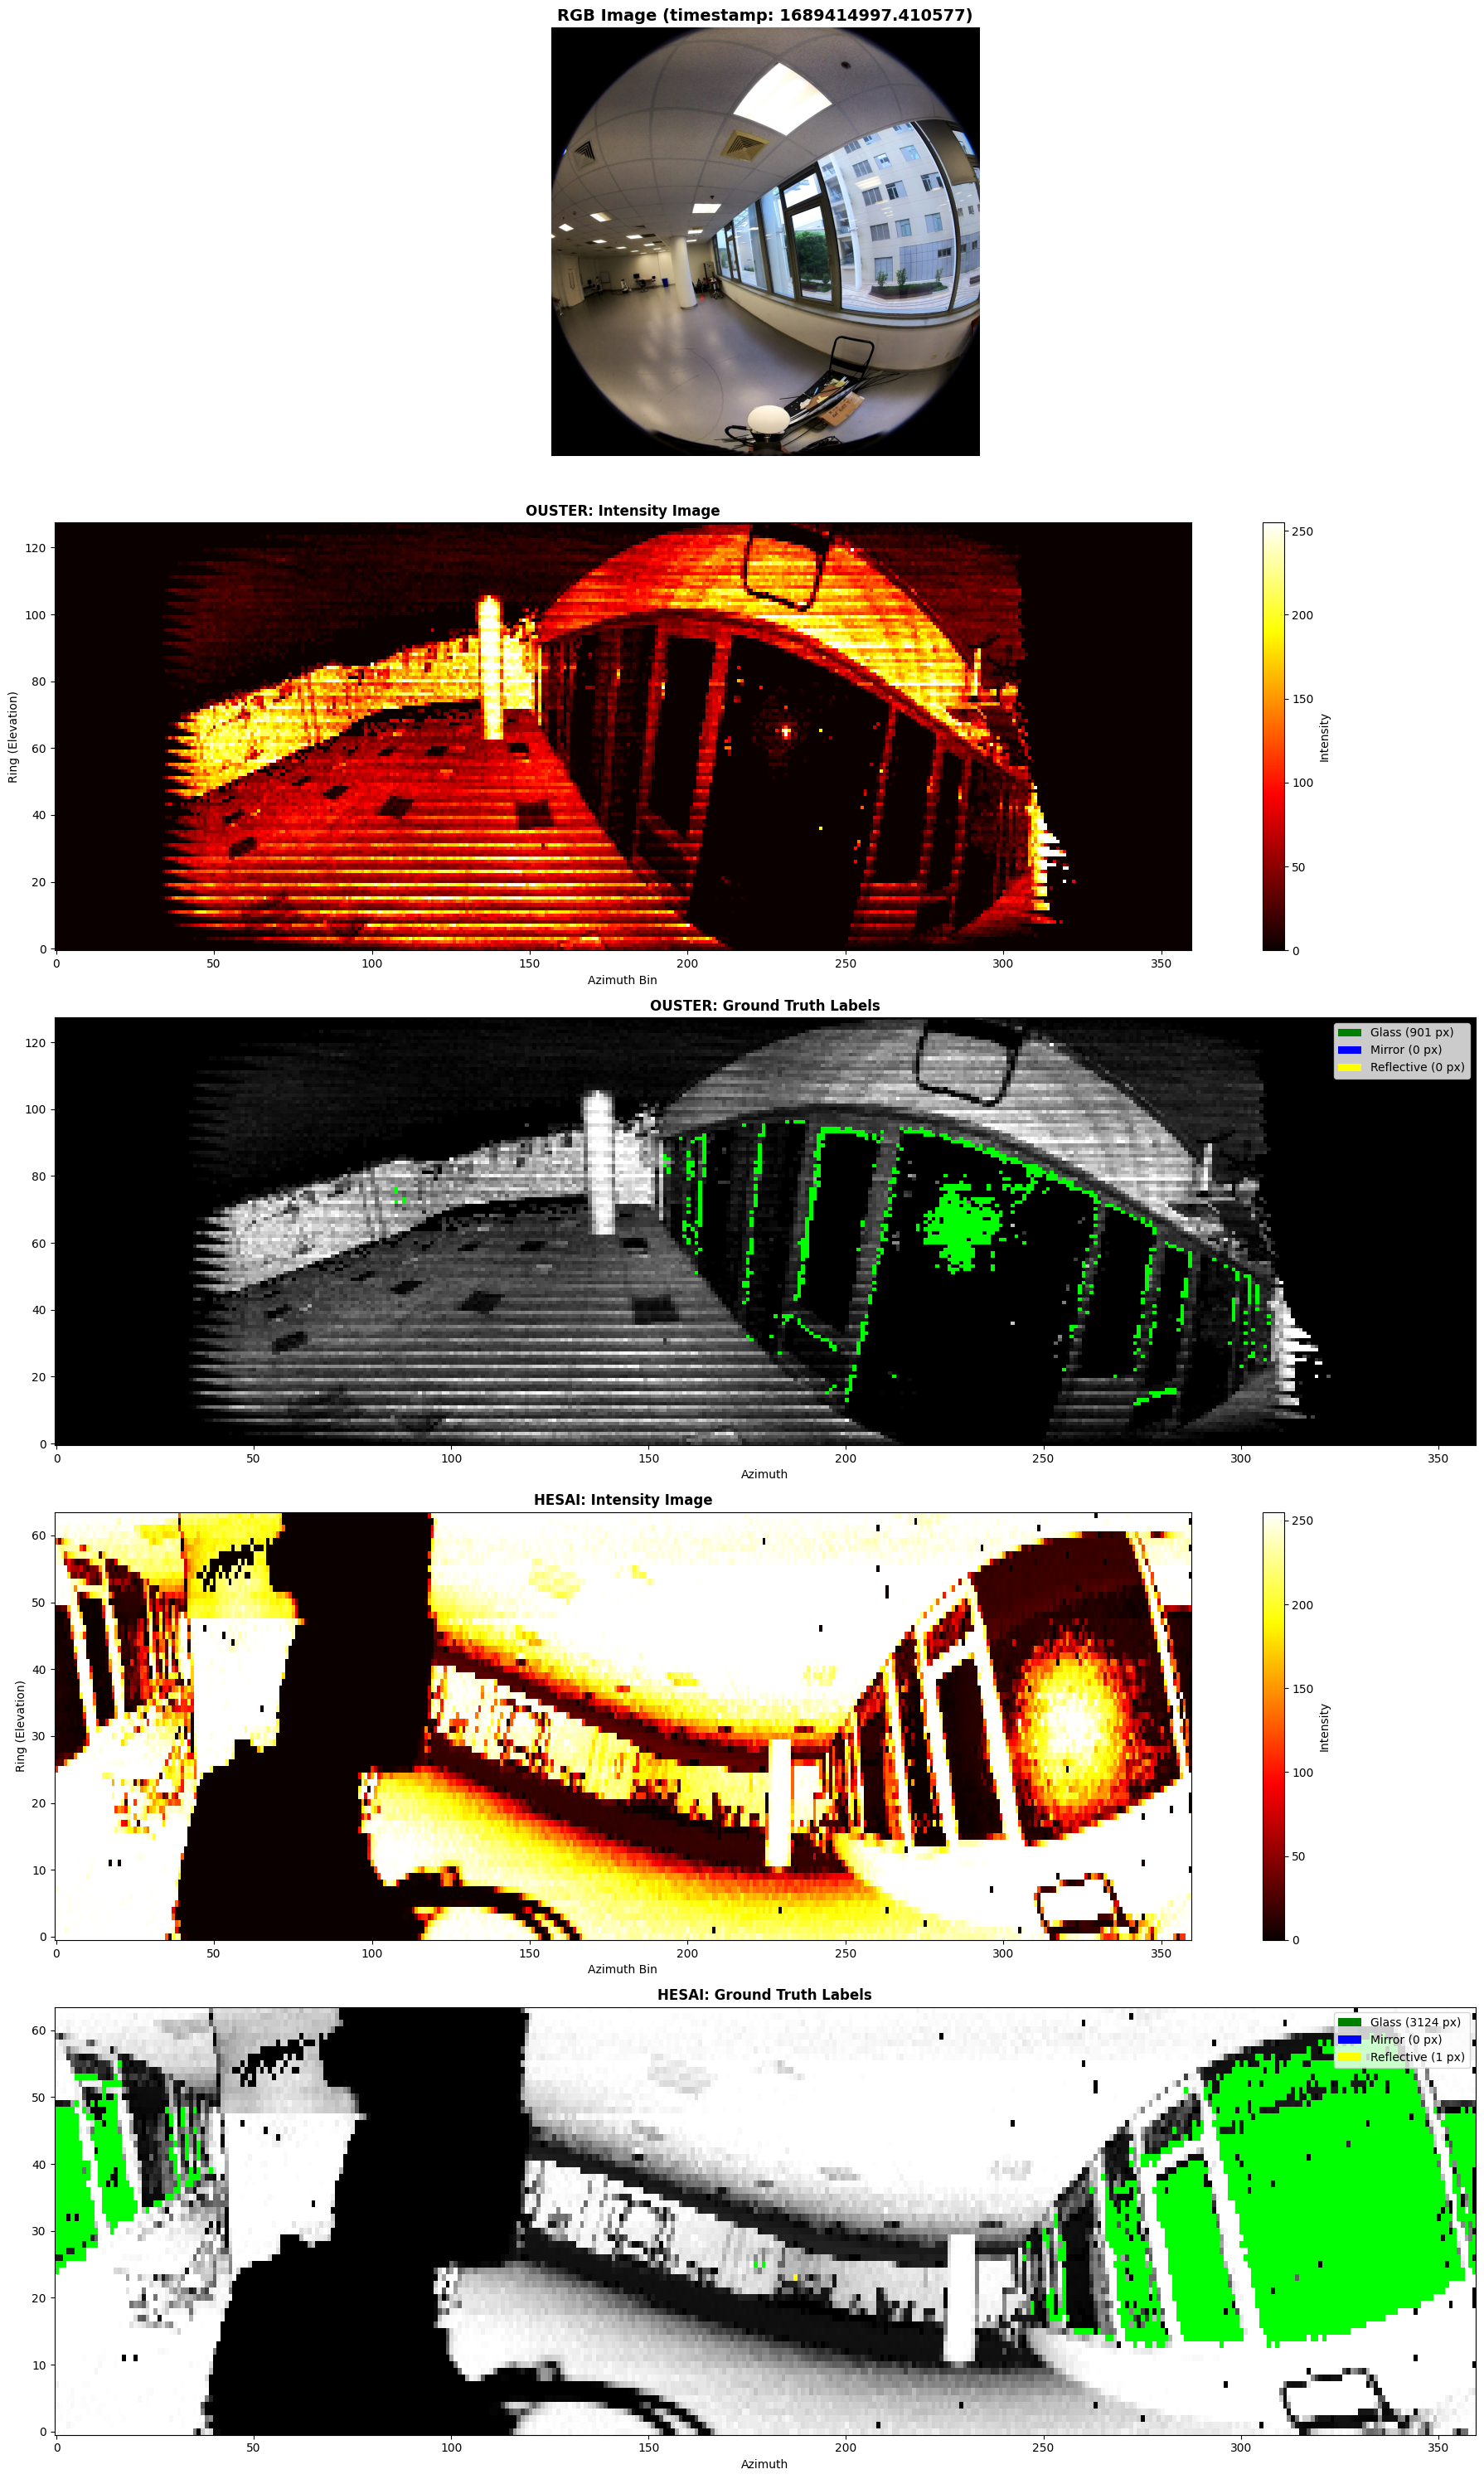


Timestamp: 1689415245.401483


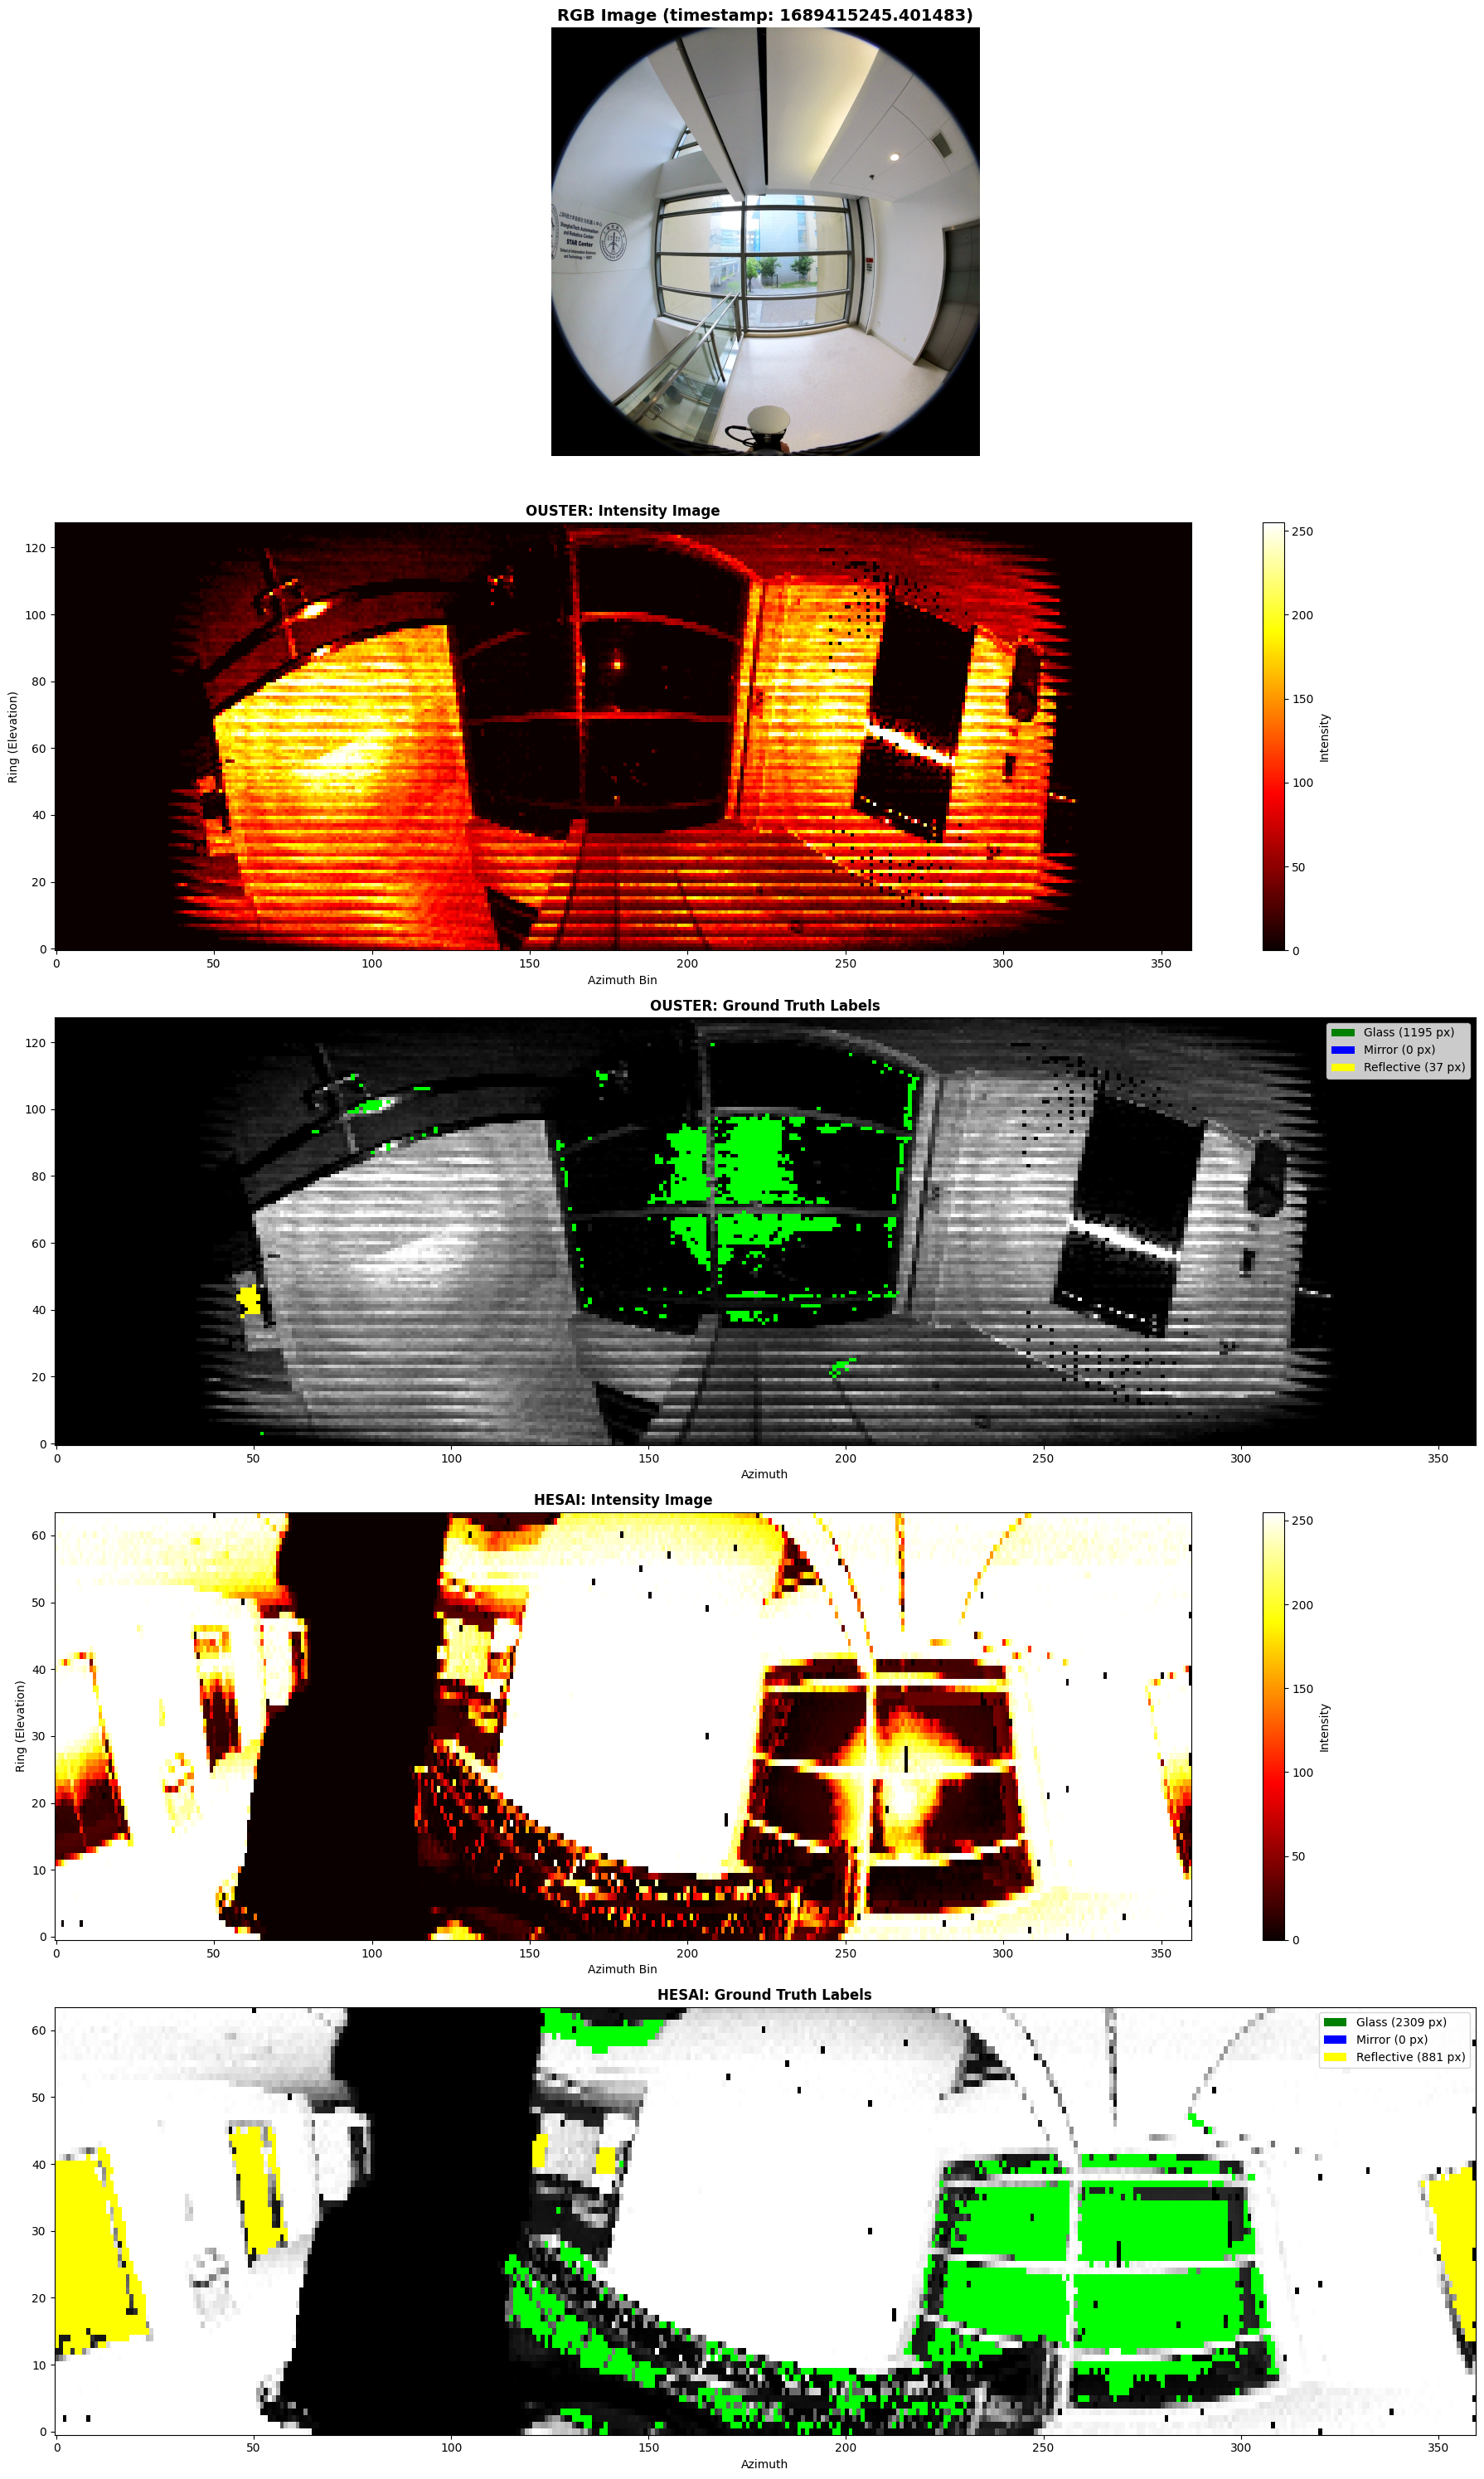


Timestamp: 1689415517.236242


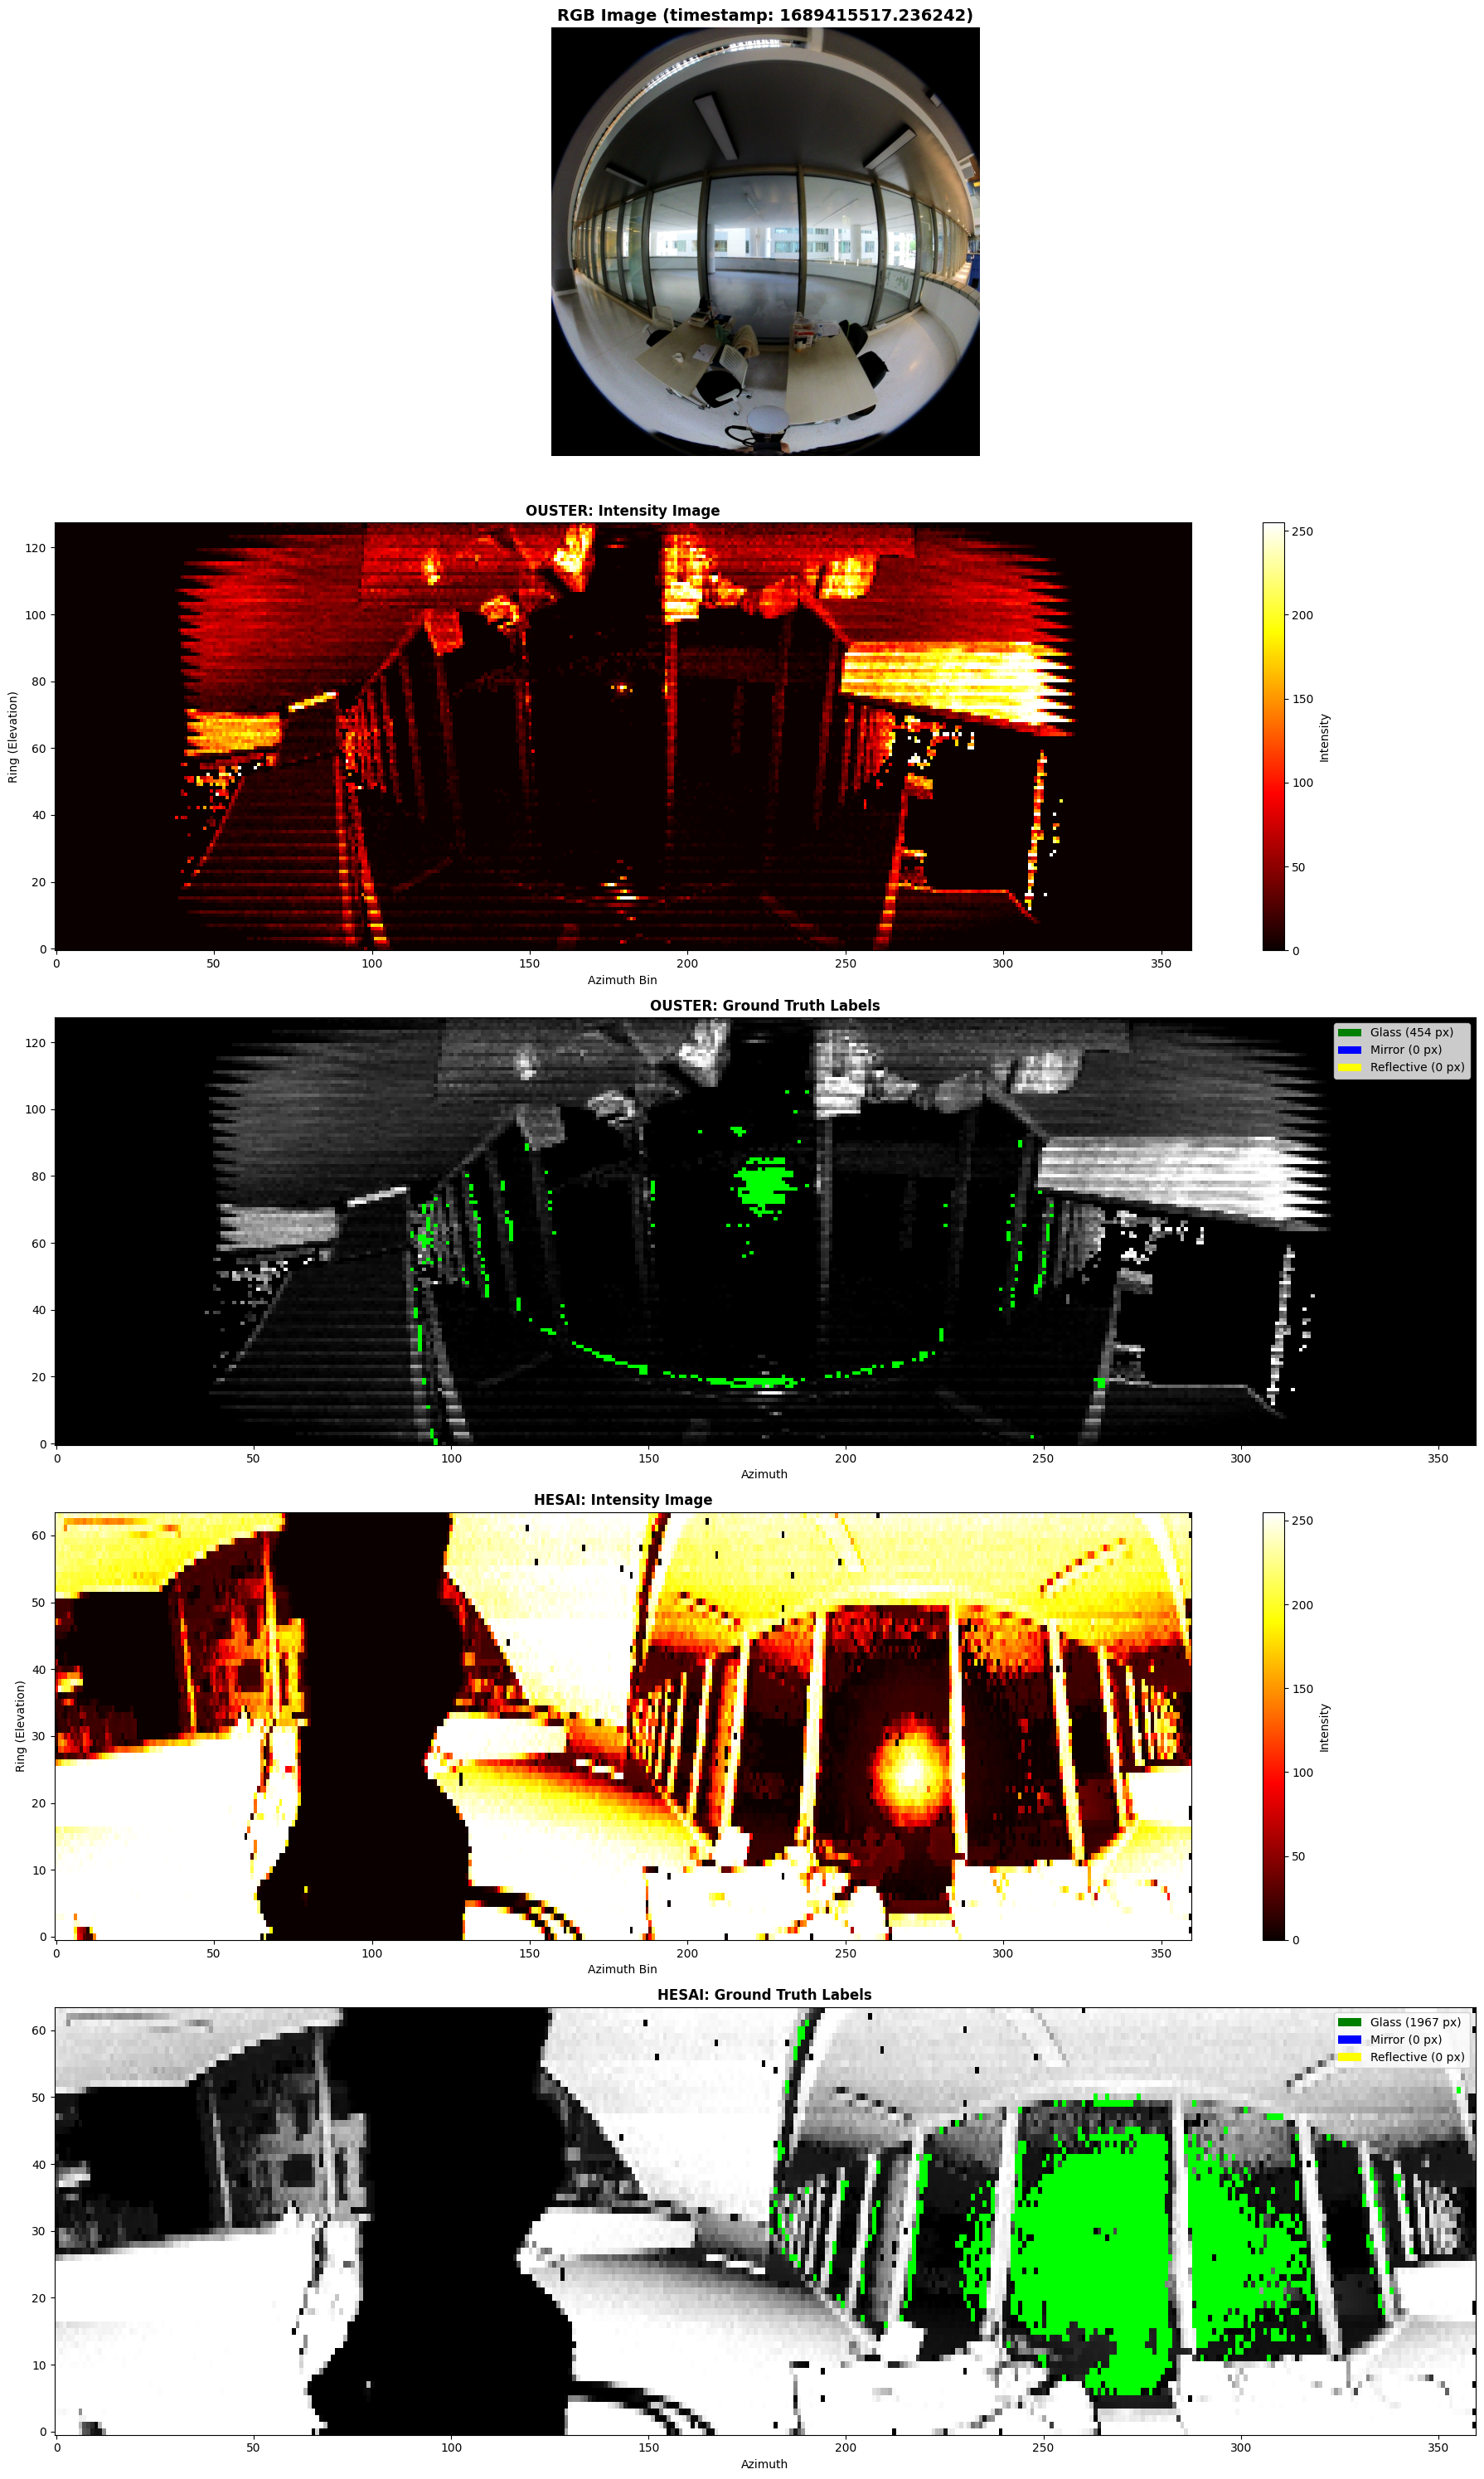

In [122]:
# Visualize all timestamps
for timestamp, sensor_data in intensity_images.items():
    print(f"\n{'='*60}")
    print(f"Timestamp: {timestamp}")
    print(f"{'='*60}")
    
    vis.show_timestamp_data(timestamp, sensor_data)

---
---
# 🎯 YOUR IMPLEMENTATION STARTS HERE

## Task: Detect Glass from Intensity Patterns

You now have:
- `timestamp_groups`: Dict mapping timestamp → {sensor: PointCloudData}
- `intensity_images`: Dict mapping timestamp → {sensor: (PointCloudData, IntensityImage)}

### What to do:
1. **Analyze the intensity images** - Look for Gaussian patterns (bright spots)
2. **Implement your detection method** - Try different approaches:
   - Blob detection (LoG, DoG)
   - Template matching
   - Morphological operations
   - Machine learning
   - Your own creative approach!
3. **Evaluate your results** - Compare with ground truth labels

### Hints:
- Glass creates **bright, circular/elliptical blobs** in the intensity image.
- The pattern is often **broken** by window frames.
- **Edges** (frames, walls) also create sharp intensity changes, but not really even close to Gaussian patterns.

### Evaluation Metrics:
```python
def evaluate(detected_mask, ground_truth_mask):
    tp = np.sum(detected_mask & ground_truth_mask)
    fp = np.sum(detected_mask & ~ground_truth_mask)
    fn = np.sum(~detected_mask & ground_truth_mask)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1
```

In [123]:
# ============================================================================
# YOUR CODE HERE
# ============================================================================

# Example: Select one timestamp and sensor to work with
timestamp = list(intensity_images.keys())[0]
sensor = 'ouster'  # or 'hesai'
pc, img = intensity_images[timestamp][sensor]

print(f"Working with: {pc}")
print(f"Intensity image shape: {img.shape}")
print(f"Ground truth glass points: {np.sum(pc.labels == 2):,}")

# TODO: Implement your glass detection method here!
# 
# Some ideas to get started:
# 1. Use the intensity image to detect glass
# 2. Apply morphological operations
# 3. Detect blobs using cv2 or scipy
# 4. Calculate gradients/Laplacian
# 5. Fit Gaussian functions

# Example placeholder:
# detected_glass_2d = (img.image > 100)  # Simple threshold

# Map back to 3D points:
# mapping = img.point_to_pixel
# detected_glass_3d = detected_glass_2d[mapping['row_indices'], mapping['col_indices']]

# Evaluate:
# ground_truth = (pc.labels == 2)
# precision, recall, f1 = evaluate(detected_glass_3d, ground_truth)
# print(f"Precision: {precision:.2%}, Recall: {recall:.2%}, F1: {f1:.2%}")

Working with: PointCloudData(ouster, 1689414997.410577.ply, 71,301 points, 128 rings)
Intensity image shape: (128, 360)
Ground truth glass points: 1,926


---
## Helper Functions

Some useful functions you might want to use:

In [124]:
def evaluate(detected_mask, ground_truth_mask):
    """Calculate precision, recall, F1 score."""
    tp = np.sum(detected_mask & ground_truth_mask)
    fp = np.sum(detected_mask & ~ground_truth_mask)
    fn = np.sum(~detected_mask & ground_truth_mask)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

def show_detection_result(img, detected_mask_2d, pc, title="Detection Result"):
    """Visualize detection result."""
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Original
    axes[0].imshow(img.image, aspect='auto', cmap='hot', origin='lower')
    axes[0].set_title("Original Intensity")
    
    # Detection
    axes[1].imshow(detected_mask_2d, aspect='auto', cmap='gray', origin='lower')
    axes[1].set_title(f"Detected Glass ({np.sum(detected_mask_2d)} px)")
    
    # Overlay
    img_rgb = np.stack([img.image]*3, axis=-1)
    img_rgb = img_rgb / np.max(img_rgb) if np.max(img_rgb) > 0 else img_rgb
    img_rgb[detected_mask_2d, 0] = 1.0  # Red = detected
    
    # Add ground truth in green
    mapping = img.point_to_pixel
    rows = mapping['row_indices'][mapping['valid_mask']]
    cols = mapping['col_indices'][mapping['valid_mask']]
    labels = pc.labels[mapping['valid_mask']]
    
    for r, c, l in zip(rows, cols, labels):
        if l == 2 and 0 <= r < img.shape[0] and 0 <= c < img.shape[1]:
            img_rgb[r, c] = [0, 1, 0]  # Green = ground truth
    
    axes[2].imshow(img_rgb, aspect='auto', origin='lower')
    axes[2].set_title("Overlay (Red=Detected, Green=GT)")
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Helper functions defined.")

Helper functions defined.


---
## References

### Papers you can refer to:
1. https://arxiv.org/abs/2406.10494
2. https://arxiv.org/html/2406.10494v1
3. https://arxiv.org/abs/2408.05608
4. https://arxiv.org/abs/2403.06538

### Tips:
- Start simple (opencv/scikit-image methods, morphology)
